In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dataExtraction(params):
    transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor()])
    img = datasets.ImageFolder(root='asl_alphabets/gan_train/',
                               transform=transform)
    dataload = torch.utils.data.DataLoader(img,**params)
    return dataload

In [3]:
params = {'batch_size': 16,
          'shuffle': False,
          'num_workers': 6}
loader = dataExtraction(params=params)

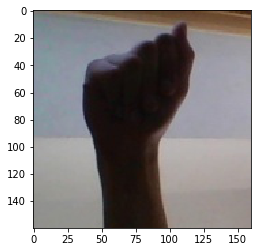

In [5]:
x,_ = next(iter(loader))
plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))

In [6]:
def tconv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.ConvTranspose2d(inp,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.ReLU()
    )
def tconv_block(a,*args,**kargs):
    layers = [tconv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

In [7]:
tconv_block([3,16,32,64], kernel_size=3, padding=1)

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [15]:
def to_rgb(in_size,*args,**kargs):
    out =3
    return nn.Sequential(
        nn.ConvTranspose2d(inp,out,*args,**kargs),
        nn.ReLU()
    )

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.dict = nn.ModuleDict({
            'layer_1': tconv_block([3,16,32,64], kernel_size=3, padding=1),
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'to_rgb_1': to_rgb(64,kernel_size=3, padding=1)
        })
    def grow(self,n,*args):
        self.dict['layer_{}'.format(n)] = tconv_block(args, kernel_size=3, padding=1)
        self.dict['to_rgb_{}'.format(n)] = to_rgb(args[-1], kernel_size=3, padding=1)
    
    def train_g(self,x,n,aplha):
        x = x.view(-1,10,10)
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i)](x)
            elif i+1 == n:
                x = self.dict['Upsample'](x)
                out = self.dict['layer_{}'.format(i)](x)
                out = self.dict['to_rgb_{}'.format(i)](out)
                x = self.dict['to_rgb_{}'.format(i-1)](x)
                x = (1-aplha)*x + aplha*(out)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i)](x)
            
        return x
                
    def forward(self,x,n):
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i)](x)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i)](x)
                
        return x

In [13]:
def conv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.Conv2d(inp,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )
def conv_block(a,*args,**kargs):
    layers = [conv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

def from_rgb(out,*args,**kargs):
    in_size = 3
    return nn.Sequential(
        nn.Conv2d(inp,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down = nn.AvgPool2d(kernel_size=2)
        self.dict = nn.ModuleDict({
            'layer_1': conv_block([64,32,16,1], kernel_size=3, padding=1),
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'from_rgb_1': from_rgb(64,kernel_size=3, padding=1)
        })
        self.linear = nn.Linear(100,1)
        self.sigmoid = nn.Sigmoid()
        
    def grow(self,n,*args):
        self.dict['layer_{}'.format(n)] = conv_block(args, kernel_size=3, padding=1)
        self.dict['from_rgb_{}'.format(n)] = from_rgb(args[0], kernel_size=3, padding=1)
        
    def train_d(self,x,n,alpha):
        for i in range(n):
            if n-i == n:
                out = self.dict['from_rgb_{}'.format(n)](x)
                out = self.dict['layer_{}'.format(n)](out)
                out = self.down(out)
                x = self.dict['from_rgb_{}'.format(n-1)](x)
                x = self.down(x)
                x = (1-aplha)*x + aplha*(out)
            elif n == 1:
                x = self.dict['from_rgb_{}'.format(n)](x)
                x = self.dict['layer_{}'.format(n)](x)
                x = x.view(-1,100)
                x = self.sigmoid(self.linear(x))
            elif i == n-1:
                x = self.dict['layer_{}'.format(n)](x)
                x = x.view(-1,100)
                x = self.sigmoid(self.linear(x))
            else:
                x = self.dict['layer_{}'.format(n-i)](x)
                x = self.down(x)
                
        return x
    
    def downSample(self,x,n):
        for i in range(n):
            x = self.down(x)
            
        return x
                